In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma0p1/fiducial/sfe_ff010/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 20)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass         isMultiple        compMass             systemMass              e                log_a               age        
-------------------- ---------- ---------------------- ------------------- ------------------- ------------------ ------------------
 0.04627343713928644        0.0                     [] 0.04627343713928644                 nan                nan 19.556162780060912
  25.885203270512562        0.0                     []  25.885203270512562                 nan                nan 18.831665142148427
  17.460593859261614        0.0                     []  17.460593859261614                 nan                nan 18.831665142148427
   34.26262484053662        0.0                     []   34.26262484053662                 nan                nan  19.42973747794478
                 ...        ...                    ...                 ...                 ...                ...                ...
 0.45910799206976305        1.0  [0.19251039711736875]  0.65161838918

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 7.252450574001908
Max log age = 7.301130918504355
Min level age = 17883419.906760104
Max level age = 20004648.208618164


In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1419
[0.1611974570734628, 0.0943345068823584, 0.016559550049036417, 0.036762464921706754, 0.06079504069721294, 0.06380029069147307, 0.03585751218111929, 0.23198170119910871, 0.014505237861303671, 0.01700157295774881, 0.03590726762690505, 0.15185415777132716, 0.016974192553383758, 0.033813877077657, 0.23609788874843576, 0.018582387823443246, 0.06421919131651019, 0.1164746761542246, 0.011075767714046215, 0.047540997935940646, 0.3236640894298204, 0.027676542925900337, 0.10202100186190528, 0.04116174703271113, 0.05504586772256095, 0.2166623824028378, 0.24503374099731445, 0.13055501878261566, 0.13042193812875036, 0.5353281358016859, 0.025192955983252337, 0.581268310546875, 0.16077175431220242, 0.07552792876958847, 0.0935800150166617, 0.5946085320749533, 0.08196223014657142, 0.07318422046273358, 0.03374142227415134, 0.013199711256715365, 0.38568341907419146, 0.13841266342427164, 0.162639881181899, 0.022449140247526474, 0.20868462114091782, 0.28994787807877465, 0.3365007399549862, 4.829887554

In [6]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[7.24303805 7.25527251 7.26717173 7.2787536  7.29003461 7.30103
 7.31175386]
[17500000. 18000000. 18500000. 19000000. 19500000. 20000000. 20500000.]


In [7]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


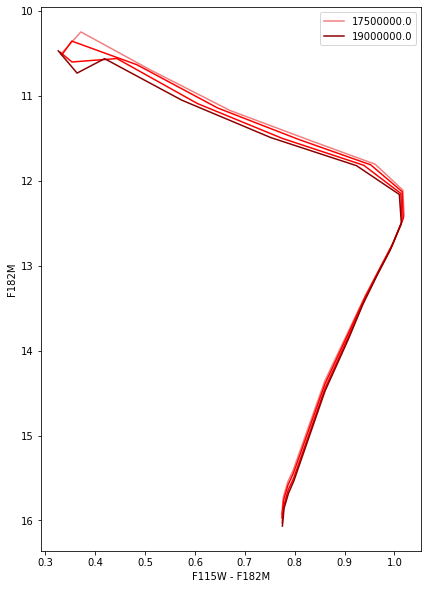

In [8]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [9]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorExp as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

Desired mass 0.04627343713928644 is outside the range of the isochrone.
Desired mass 0.04627343713928644 is outside the range of the isochrone.
Desired mass 25.885203270512562 is outside the range of the isochrone.
Desired mass 25.885203270512562 is outside the range of the isochrone.
Desired mass 17.460593859261614 is outside the range of the isochrone.
Desired mass 17.460593859261614 is outside the range of the isochrone.
Desired mass 34.26262484053662 is outside the range of the isochrone.
Desired mass 34.26262484053662 is outside the range of the isochrone.
Desired mass 19.39913770552841 is outside the range of the isochrone.
Desired mass 19.39913770552841 is outside the range of the isochrone.
Desired mass 0.05574679971238722 is outside the range of the isochrone.
Desired mass 0.05574679971238722 is outside the range of the isochrone.
Desired mass 0.04019372055706843 is outside the range of the isochrone.
Desired mass 0.04019372055706843 is outside the range of the isochrone.
Desi

Desired mass 0.02799317508459064 is outside the range of the isochrone.
Desired mass 0.02799317508459064 is outside the range of the isochrone.
Desired mass 5.212394866953984 is outside the range of the isochrone.
Desired mass 5.212394866953984 is outside the range of the isochrone.
Desired mass 0.06387925148010254 is outside the range of the isochrone.
Desired mass 0.06387925148010254 is outside the range of the isochrone.
Desired mass 0.026857323033955088 is outside the range of the isochrone.
Desired mass 0.026857323033955088 is outside the range of the isochrone.
Desired mass 0.05994034176493652 is outside the range of the isochrone.
Desired mass 0.05994034176493652 is outside the range of the isochrone.
Desired mass 0.028354630133159402 is outside the range of the isochrone.
Desired mass 0.028354630133159402 is outside the range of the isochrone.
Desired mass 0.06134724643761715 is outside the range of the isochrone.
Desired mass 0.06134724643761715 is outside the range of the iso

Desired mass 0.033893154066880454 is outside the range of the isochrone.
Desired mass 0.033893154066880454 is outside the range of the isochrone.
Desired mass 3.4479564794190387 is outside the range of the isochrone.
Desired mass 3.4479564794190387 is outside the range of the isochrone.
Desired mass 0.023013322788859633 is outside the range of the isochrone.
Desired mass 0.023013322788859633 is outside the range of the isochrone.
Desired mass 0.049750424439747566 is outside the range of the isochrone.
Desired mass 0.049750424439747566 is outside the range of the isochrone.
Desired mass 0.01742778651172629 is outside the range of the isochrone.
Desired mass 0.01742778651172629 is outside the range of the isochrone.
Desired mass 0.033228705319893526 is outside the range of the isochrone.
Desired mass 0.033228705319893526 is outside the range of the isochrone.
Desired mass 0.01475624739275161 is outside the range of the isochrone.
Desired mass 0.01475624739275161 is outside the range of t

Desired mass 0.015177205091759126 is outside the range of the isochrone.
Desired mass 0.015177205091759126 is outside the range of the isochrone.
Desired mass 0.01866748556494713 is outside the range of the isochrone.
Desired mass 0.01866748556494713 is outside the range of the isochrone.
Desired mass 0.014877856841797314 is outside the range of the isochrone.
Desired mass 0.014877856841797314 is outside the range of the isochrone.
Desired mass 1.6665511253972003 is outside the range of the isochrone.
Desired mass 1.6665511253972003 is outside the range of the isochrone.
Desired mass 0.026923485222296456 is outside the range of the isochrone.
Desired mass 0.026923485222296456 is outside the range of the isochrone.
Desired mass 0.06826177826854322 is outside the range of the isochrone.
Desired mass 0.06826177826854322 is outside the range of the isochrone.
Desired mass 0.02822247044272336 is outside the range of the isochrone.
Desired mass 0.02822247044272336 is outside the range of the

Desired mass 1.5524855417018992 is outside the range of the isochrone.
Desired mass 1.5524855417018992 is outside the range of the isochrone.
Desired mass 2.558337256288068 is outside the range of the isochrone.
Desired mass 2.558337256288068 is outside the range of the isochrone.
Desired mass 0.048726105176069213 is outside the range of the isochrone.
Desired mass 0.048726105176069213 is outside the range of the isochrone.
Desired mass 2.632386671522017 is outside the range of the isochrone.
Desired mass 2.632386671522017 is outside the range of the isochrone.
Desired mass 0.03505099590455935 is outside the range of the isochrone.
Desired mass 0.03505099590455935 is outside the range of the isochrone.
Desired mass 0.04752854625895147 is outside the range of the isochrone.
Desired mass 0.04752854625895147 is outside the range of the isochrone.
Desired mass 0.03338211724092174 is outside the range of the isochrone.
Desired mass 0.03338211724092174 is outside the range of the isochrone.


Desired mass 0.03604747393168002 is outside the range of the isochrone.
Desired mass 0.03604747393168002 is outside the range of the isochrone.
Desired mass 0.06429834712755733 is outside the range of the isochrone.
Desired mass 0.06429834712755733 is outside the range of the isochrone.
Desired mass 0.017212924007481357 is outside the range of the isochrone.
Desired mass 0.017212924007481357 is outside the range of the isochrone.
Desired mass 0.010770044056465582 is outside the range of the isochrone.
Desired mass 0.010770044056465582 is outside the range of the isochrone.
Desired mass 0.010512500503218359 is outside the range of the isochrone.
Desired mass 0.010512500503218359 is outside the range of the isochrone.
Desired mass 0.04177751660679248 is outside the range of the isochrone.
Desired mass 0.04177751660679248 is outside the range of the isochrone.
Desired mass 9.528755406103638 is outside the range of the isochrone.
Desired mass 9.528755406103638 is outside the range of the i

Desired mass 0.05962646649923525 is outside the range of the isochrone.
Desired mass 0.05962646649923525 is outside the range of the isochrone.
Desired mass 0.022138356883477452 is outside the range of the isochrone.
Desired mass 0.022138356883477452 is outside the range of the isochrone.
Desired mass 0.04520890516408778 is outside the range of the isochrone.
Desired mass 0.04520890516408778 is outside the range of the isochrone.
Desired mass 5.5017711436269625 is outside the range of the isochrone.
Desired mass 5.5017711436269625 is outside the range of the isochrone.
Desired mass 0.06005631669010254 is outside the range of the isochrone.
Desired mass 0.06005631669010254 is outside the range of the isochrone.
Desired mass 0.036496690119965085 is outside the range of the isochrone.
Desired mass 0.036496690119965085 is outside the range of the isochrone.
Desired mass 0.036670920009415124 is outside the range of the isochrone.
Desired mass 0.036670920009415124 is outside the range of the

Desired mass 0.018677622764121993 is outside the range of the isochrone.
Desired mass 0.018677622764121993 is outside the range of the isochrone.
Desired mass 0.015057240526950493 is outside the range of the isochrone.
Desired mass 0.015057240526950493 is outside the range of the isochrone.
Desired mass 0.06241434795672451 is outside the range of the isochrone.
Desired mass 0.06241434795672451 is outside the range of the isochrone.
Desired mass 0.01863042146230188 is outside the range of the isochrone.
Desired mass 0.01863042146230188 is outside the range of the isochrone.
Desired mass 0.013878994394993892 is outside the range of the isochrone.
Desired mass 0.013878994394993892 is outside the range of the isochrone.
Desired mass 0.06679677771674185 is outside the range of the isochrone.
Desired mass 0.06679677771674185 is outside the range of the isochrone.
Desired mass 0.017995712499633533 is outside the range of the isochrone.
Desired mass 0.017995712499633533 is outside the range of

Desired mass 0.02265318624267274 is outside the range of the isochrone.
Desired mass 0.02265318624267274 is outside the range of the isochrone.
Desired mass 0.054437130477310636 is outside the range of the isochrone.
Desired mass 0.054437130477310636 is outside the range of the isochrone.
Desired mass 0.040982530041602995 is outside the range of the isochrone.
Desired mass 0.040982530041602995 is outside the range of the isochrone.
Desired mass 0.011620639769698753 is outside the range of the isochrone.
Desired mass 0.011620639769698753 is outside the range of the isochrone.
Desired mass 0.04438013242713808 is outside the range of the isochrone.
Desired mass 0.04438013242713808 is outside the range of the isochrone.
Desired mass 0.017364433670433874 is outside the range of the isochrone.
Desired mass 0.017364433670433874 is outside the range of the isochrone.
Desired mass 1.5782018241813167 is outside the range of the isochrone.
Desired mass 1.5782018241813167 is outside the range of t

Desired mass 0.06273460313442222 is outside the range of the isochrone.
Desired mass 0.06273460313442222 is outside the range of the isochrone.
Desired mass 0.033954333548963496 is outside the range of the isochrone.
Desired mass 0.033954333548963496 is outside the range of the isochrone.
Desired mass 0.05704627331789884 is outside the range of the isochrone.
Desired mass 0.05704627331789884 is outside the range of the isochrone.
Desired mass 0.023918237507004798 is outside the range of the isochrone.
Desired mass 0.023918237507004798 is outside the range of the isochrone.
Desired mass 0.04261818657839866 is outside the range of the isochrone.
Desired mass 0.04261818657839866 is outside the range of the isochrone.
Desired mass 12.68180692151572 is outside the range of the isochrone.
Desired mass 12.68180692151572 is outside the range of the isochrone.
Desired mass 0.05834737301441206 is outside the range of the isochrone.
Desired mass 0.05834737301441206 is outside the range of the iso

Desired mass 0.027404028578224462 is outside the range of the isochrone.
Desired mass 0.027404028578224462 is outside the range of the isochrone.
Desired mass 0.018542128176928158 is outside the range of the isochrone.
Desired mass 0.018542128176928158 is outside the range of the isochrone.
Desired mass 11.046585839738983 is outside the range of the isochrone.
Desired mass 11.046585839738983 is outside the range of the isochrone.
Desired mass 0.04706695521646092 is outside the range of the isochrone.
Desired mass 0.04706695521646092 is outside the range of the isochrone.
Desired mass 0.014642653531041586 is outside the range of the isochrone.
Desired mass 0.014642653531041586 is outside the range of the isochrone.
Desired mass 0.05050815146783093 is outside the range of the isochrone.
Desired mass 0.05050815146783093 is outside the range of the isochrone.
Desired mass 0.01557887461396658 is outside the range of the isochrone.
Desired mass 0.01557887461396658 is outside the range of the

[0.019057601464786876, 3231.081, 4.422, 15.482, 14.631]
[0.11549124880963582, 3788.155, 4.446, 13.699, 12.699]
[0.009152853488792549, 3070.235, 4.41, 16.204, 15.403]
None
[0.015342032996623577, 3161.081, 4.404, 15.76, 14.931]
None
None
[0.007063855627710508, 3007.091, 4.386, 16.428, 15.646]
[0.011403028762594188, 3097.516, 4.394, 16.032, 15.223]
[0.07773790213150128, 3594.026, 4.407, 14.049, 13.083]
None
[0.006560968148343239, 3010.147, 4.423, 16.511, 15.726]
[0.03555604272527439, 3376.88, 4.414, 14.821, 13.919]
[0.03807693724876437, 3396.052, 4.414, 14.74, 13.832]
[0.005052659071385068, 2949.912, 4.423, 16.774, 15.999]
[0.043588321269169276, 3431.599, 4.42, 14.625, 13.707]
None
[0.16716225056881484, 3963.333, 4.43, 13.355, 12.34]
[0.007538382358606826, 3044.76, 4.428, 16.37, 15.576]
[0.009278422781658828, 3067.435, 4.396, 16.18, 15.38]
[0.007181398830765345, 3010.88, 4.386, 16.411, 15.628]
[0.024697731284009667, 3273.027, 4.385, 15.177, 14.311]
[0.006890293228324618, 3001.425, 4.386, 

None
[0.014274495962812094, 3138.55, 4.393, 15.833, 15.01]
[0.010729073400101116, 3088.274, 4.396, 16.08, 15.273]
[0.016428263885886647, 3169.026, 4.391, 15.683, 14.851]
[0.007155992950664828, 3010.479, 4.386, 16.415, 15.632]
None
[0.07768954490208012, 3594.33, 4.408, 14.05, 13.084]
[0.028856141986997718, 3304.293, 4.385, 15.042, 14.164]
[0.08994664208193283, 3651.324, 4.413, 13.916, 12.937]
None
None
[0.005475900245014637, 2949.929, 4.387, 16.686, 15.911]
[0.022627944091450938, 3256.872, 4.386, 15.251, 14.391]
[0.017485605099547732, 3183.982, 4.39, 15.609, 14.772]
[0.014402919013441623, 3140.286, 4.392, 15.824, 15.001]
None
[0.027954009028329556, 3297.532, 4.385, 15.072, 14.196]
[0.034174683959875087, 3343.594, 4.385, 14.869, 13.976]
None
[0.4784615483603995, 4664.494, 4.384, 12.362, 11.536]
[0.034692825036441166, 3347.348, 4.384, 14.852, 13.958]
[0.01833076391938846, 3195.741, 4.389, 15.551, 14.71]
[0.020691773657510897, 3229.169, 4.387, 15.386, 14.535]
None
[0.07809511883840933, 359

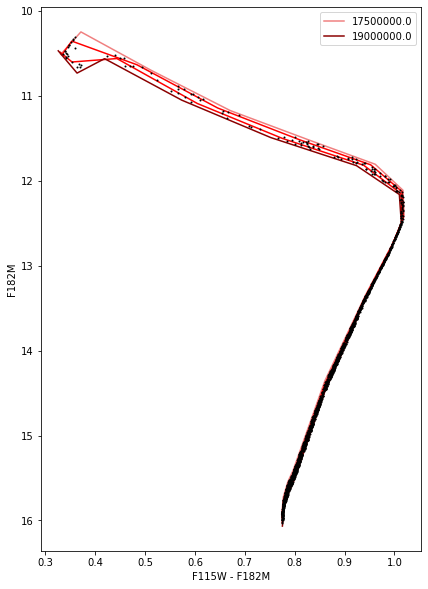

In [10]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
